In [1]:
from mesh import Mesh
from boundary import Boundary
from parameters import kp, km, conc_rac, conc_gfp, T0
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math
%matplotlib inline

In [2]:
print("km:", km)
print("kp:", kp)
print("conc_rac:", conc_rac)
print("conc_gfp:", conc_gfp)

km: 0.23000000000000007
kp: 11.839878157810809
conc_rac: 1.111111111111111
conc_gfp: 1.0


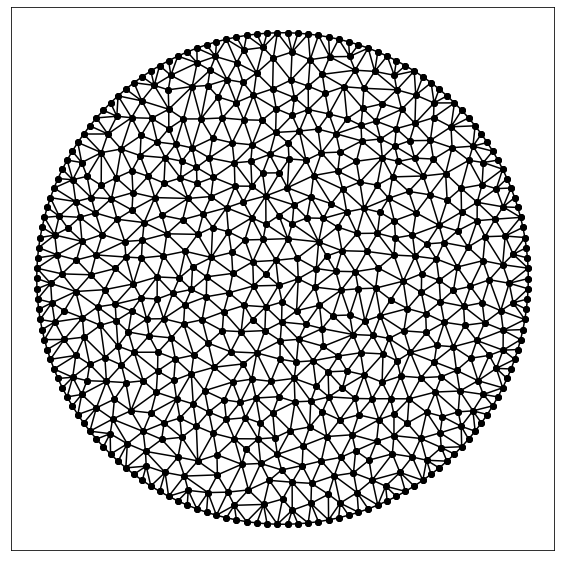

In [3]:
# Create mesh
mesh = Mesh(150, min_size=0.005, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Heat Equation with von Neumann Coupled Boundary

- Implicit time-stepping
- PDE: $\frac{\partial u} {\partial t} = \nabla^2 u$
- von Neumann coupled to kinetics: $\partial_n u(x,y) = -\dot{u_b}$
- Kinetic equation: $\dot{u_b} = k_+ u (r_0 - u_b) - k_- u_b$
- Initial state: $u=1$
- Rac activation: 10% around entire cell

### Analytical solution

In [4]:
ACTIVE_RAC = 1e-1
a = 2.0
r0 = conc_rac*ACTIVE_RAC
b = -(1.0 + 2.0*r0 + km/kp)
c = r0
# print(a, b, c)
u_b0 = (-b - math.sqrt(b**2 - 4.0*a*c))/(2.0*a)
print("Bound GFP:", u_b0)
u_0 = 1.0 - 2.0*u_b0
print("Free GFP:", u_0)

Bound GFP: 0.10842175397188453
Free GFP: 0.783156492056231


### Numerical Solution

dt: 0.005999999999999998


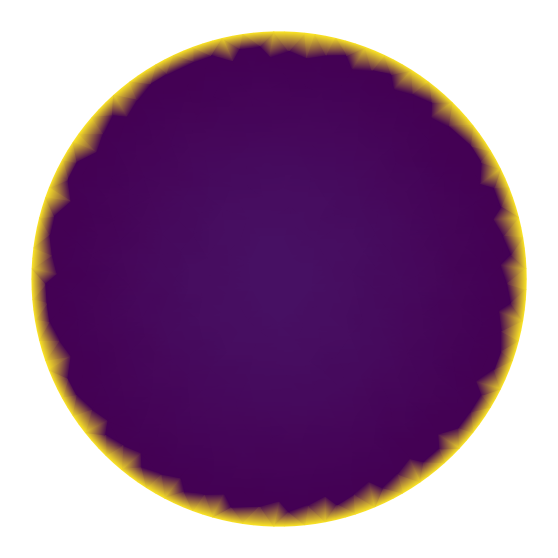

In [5]:
def calculate_initial_condition(vertex):
    return conc_gfp

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def generate_boundary_values(boundary, u):
    return -1*boundary.calc_ddt(u)

def print_integration(u, ub):
    print("Total GFP: ", mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp))
    print("Cytoplasma: ", mesh.integrate(u))
    print("Boundary: ", mesh.integrate_around_edge(boundary.bound_gfp))
    
def print_change(u0, u, ub):
    total_before = mesh.integrate(u0)
    total_after = mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp)
    print("Change in total GFP:", total_after - total_before)

total_time = 2.0 # in seconds
total_steps = 100
T = total_time/T0
dt = T/total_steps
print("dt:", dt)
t = 0.0

# Set active Rac
boundary = Boundary(mesh.n_vertices, mesh.boundary_vertices, km, kp)
boundary.set_active_rac(conc_rac*ACTIVE_RAC)

# Initial conditions
u_prev = set_initial_conditions(mesh)

# Assemble matrices
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()

# Solve
lhs_matrix = dt*stiffness + mass

u_list = []

while t<T:
    boundary_values = generate_boundary_values(boundary, u_prev)
    boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

    rhs_vector = dt*boundary_vector + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    
    boundary.update(dt)
    
    u_list.append(np.zeros_like(u_prev))
    u_list[-1][:] = u_prev[:] + boundary.bound_gfp[:]
    
    t+=dt

soln = u_next + boundary.bound_gfp

fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, ax)
plt.show()

print_change(u0, u_next, boundary)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))

def animate(i):
    plot = mesh.plot(u_list[i], ax)
    return plot,

total_frames = len(u_list)

anim = FuncAnimation(fig, animate,
                               frames=total_frames, interval=int(1.0*1e3*(total_time/total_frames)), blit=True)
HTML(anim.to_html5_video())

- Active Rac now sinusoidal around membrane

def calculate_initial_condition(vertex):
    return conc_gfp

def set_initial_conditions(mesh):
    return np.array(list(map(calculate_initial_condition, mesh.vertices())))

def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def generate_boundary_values(mesh, boundary, u):
    return -1*boundary.calculate_ddt(u, mesh.boundary_vertices)

def print_integration(u, ub):
    print("Total GFP: ", mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp))
    print("Cytoplasma: ", mesh.integrate(u))
    print("Boundary: ", mesh.integrate_around_edge(boundary.bound_gfp))
    
def print_change(u0, u, ub):
    total_before = mesh.integrate(u0)
    total_after = mesh.integrate(u) + mesh.integrate_around_edge(boundary.bound_gfp)
    print("Change in total GFP:", total_after - total_before)

total_time = 1.0 # in seconds
total_steps = 100
n_frames = 50

T = total_time/T0
dt = T/(total_steps+1)
dt_frame = T/(n_frames+1)
print("dt:",dt)
t = 0.0

# Set active Rac
boundary = Boundary(mesh.n_vertices)
for index in mesh.boundary_vertices:
    theta = theta_from_vertex(mesh.get_pos(index))
    if theta > 0:
        boundary.active_rac[index] = conc_rac*1e-1*np.sin(theta)
    else:
        boundary.active_rac[index] = -conc_rac*1.2e-1*np.sin(theta)


# Initial conditions
u_prev = set_initial_conditions(mesh)

# Assemble matrices
stiffness = mesh.assemble_stiffness()
mass = mesh.assemble_mass()
force_vector = np.zeros(mesh.n_vertices) # No reaction term within cell body

# Solve
lhs_matrix = dt*stiffness + mass

t_frame = 0.0
u_list = []

while t<T:
    boundary_values = generate_boundary_values(mesh, boundary, u_prev)
    boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

    rhs_vector = dt*(force_vector + boundary_vector) + mass.dot(u_prev)
    u_next = np.linalg.solve(lhs_matrix, rhs_vector)
    u_prev[:] = u_next[:]
    
    boundary.update_bound(u_prev, dt, mesh.boundary_vertices)
    
    if t_frame > dt_frame:
        u_list.append(np.zeros_like(u_prev))
        u_list[-1][:] = u_prev[:] + boundary.bound_gfp[:]
        t_frame = 0.0
    else:
        t_frame += dt
    
    t+=dt

soln = u_next + boundary.bound_gfp

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# plot = mesh.plot(soln, ax)
# ax.set_title('Solution')

# print(u_list[0])
print(len(u_list))

def animate(i):
    plot = mesh.plot(u_list[i], ax)
    return plot,

total_frames = len(u_list)

anim = FuncAnimation(fig, animate,
                               frames=total_frames, interval=int(1.0*1e3*(total_time/total_frames)), blit=True)
HTML(anim.to_html5_video())